Node A:
	distance to A: 0
	distance to C: 3
	distance to B: 1
Node C:
	distance to A: 3
	distance to C: 0
	distance to B: 2
Node B:
	distance to A: 1
	distance to C: 2
	distance to B: 0


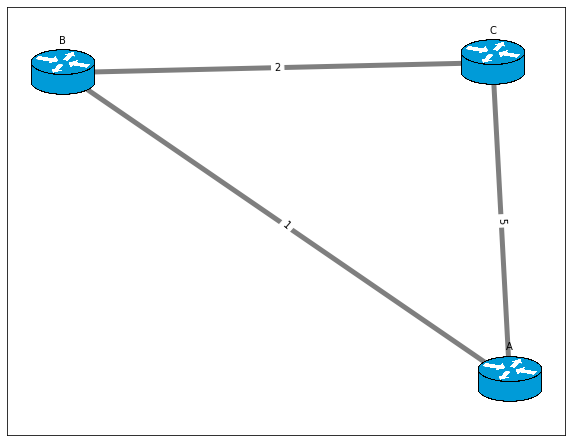

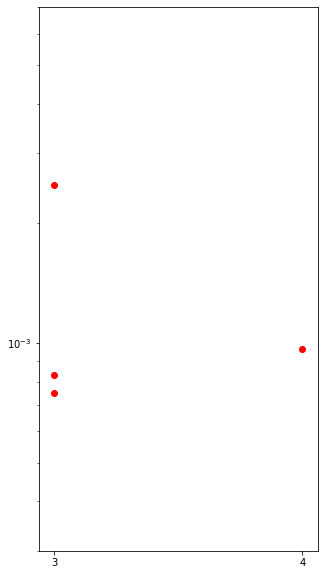

In [7]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import time
import PIL
import csv
import os
from openpyxl import Workbook
from openpyxl import load_workbook
from collections import defaultdict
from openpyxl.styles import Alignment
from openpyxl.utils import get_column_letter


class Node:
    def __init__(self, name):
        self.name = name
        self.neighbors = {}
        self.distance_table = {}

    def add_neighbor(self, neighbor, cost):
        self.neighbors[neighbor] = cost

    def update_distance_table(self):
        for neighbor, neighbor_cost in self.neighbors.items():
            for destination, dest_cost in neighbor.distance_table.items():
                new_cost = neighbor_cost + dest_cost
                if destination not in self.distance_table or new_cost < self.distance_table[destination]:
                    self.distance_table[destination] = new_cost

def distance_vector(nodes):
    for node in nodes:
        for destination in nodes:
            if node == destination:
                node.distance_table[destination] = 0
            elif destination in node.neighbors:
                node.distance_table[destination] = node.neighbors[destination]
            else:
                node.distance_table[destination] = float('inf')

    for _ in range(len(nodes) - 1):
        for node in nodes:
            node.update_distance_table()

    for node in nodes:
        print(f"Node {node.name}:")
        for destination, cost in node.distance_table.items():
            if cost == float('inf'):
                cost = "∞"
            print(f"\tdistance to {destination.name}: {cost}")

# Read the Excel file
df = pd.read_excel('Network Graph Information.xlsx')

# Get the number of nodes
num_nodes = len(set(df['Start Node'].tolist() + df['End Node'].tolist()))

# Get the names of the nodes
nodes = list(set(df['Start Node'].tolist() + df['End Node'].tolist()))

# Initialize nodes
nodes = [Node(node_name) for node_name in nodes]

# Initialize edges
try:
    for start_node_name, end_node_name, cost in zip(df['Start Node'], df['End Node'], df['Cost']):
        start_node = next(node for node in nodes if node.name == start_node_name)
        end_node = next(node for node in nodes if node.name == end_node_name)
        start_node.add_neighbor(end_node, cost)
        end_node.add_neighbor(start_node, cost)
except KeyError:
    print('One or more columns do not exist in the DataFrame.')

# Measure the runtime of the algorithm
start_time = time.perf_counter()
distance_vector(nodes)
end_time = time.perf_counter()

# Calculate the Vector Distance's algorithm execution time
vc_execution_time = end_time - start_time

# Check if the file already exists
file_path = 'Execution Times - Number of Nodes.xlsx'
if os.path.isfile(file_path):
    # Read the existing data from the file
    existing_data = pd.read_excel(file_path)
    
    # Append the new data to the existing data
    execution_times_df = pd.concat([existing_data, pd.DataFrame({
        'Number of Nodes': [num_nodes],
        'Vector Distance Execution Time (seconds)': [vc_execution_time]
    })], ignore_index=True)
else:
    # Create a new DataFrame with the data
    execution_times_df = pd.DataFrame({
        'Number of Nodes': [num_nodes],
        'Vector Distance Execution Time (seconds)': [vc_execution_time]
    })

# Save the updated data to the Excel file
execution_times_df.to_excel(file_path, index=False)

# Load the workbook
wb = load_workbook(filename=file_path)

# Get the active worksheet
ws = wb.active

# Set column width
for col in ws.columns:
    max_length = 0
    column = col[0].column_letter
    for cell in col:
        try:
            if len(str(cell.value)) > max_length:
                max_length = len(cell.value)
        except:
            pass
    adjusted_width = (max_length + 2)
    ws.column_dimensions[column].width = adjusted_width
    
# Center content
for row in ws.iter_rows():
    for cell in row:
        cell.alignment = Alignment(horizontal='center', vertical='center')

# Save the workbook
wb.save(filename=file_path)

# Visualizing the graph (nodes and edges)
G = nx.Graph()
for node in nodes:
    G.add_node(node.name)
try:
    for start_node_name, end_node_name, cost in zip(df['Start Node'], df['End Node'], df['Cost']):
        G.add_edge(start_node_name, end_node_name, weight=cost)
except KeyError:
    print('One or more columns do not exist in the DataFrame.')
pos = nx.spring_layout(G)

# Load the image
img = PIL.Image.open('C:\\Users\\mosi1\\Python Projects\\CE - Network 2\\Distance Vector Project\\Router Symbol Blue.svg')

# Specify the figure size
plt.figure(figsize=(10, 10)) # 15:10 represents a 3:4 aspect ratio

# Draw nodes
for node, coords in pos.items():
    x, y = coords
    plt.imshow(img, extent=(x-0.19, x+0.19, y-0.19, y+0.19), origin='upper', zorder=1)

# Draw labels
labels = {node: node for node in G.nodes}
for node, label in labels.items():
    x, y = pos[node]
    plt.text(x, y + 0.1, label, fontsize=10, ha='center')

# Draw edges
nx.draw_networkx_edges(G, pos, width=5, alpha=0.5)

# Draw edge labels
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=10, font_color='black')

plt.show()

# Visualizing the execution time - number of nodes
execution_times_df = pd.read_excel('Execution Times - Number of Nodes.xlsx')

# Specify the figure size
plt.figure(figsize=(5, 10))  # 15:10 represents a 3:4 aspect ratio

# Now plot the data
plt.scatter(execution_times_df['Number of Nodes'], execution_times_df['Vector Distance Execution Time (seconds)'], marker='o', linestyle='-', color='red')

# Set y-axis to logarithmic scale
plt.yscale('log')

# Set the range of y-axis
plt.ylim([0.0003, 0.007])

# Force integer ticks on the x-axis
plt.xticks(range(execution_times_df['Number of Nodes'].min(), execution_times_df['Number of Nodes'].max() + 1))

plt.show()